In [1]:
!pip install torch

In [1]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import numpy as np
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision import models
from tqdm import tqdm
import os
import torchvision

In [2]:
transformations = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [5]:
dataset = datasets.ImageFolder(
          root='/home/kira/DL_CMC/food-101/images',
          transform=transformations)

In [7]:
n = len(dataset)  
n_test = int(0.2 * n) 
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [n - n_test, n_test])

In [8]:
train_loader = torch.utils.data.DataLoader(
            train_dataset, 
            batch_size=8,
            shuffle=True, 
            num_workers=4)

val_loader = torch.utils.data.DataLoader(
            val_dataset, 
            batch_size=8,
            shuffle=True, 
            num_workers=4)

Пробуем резнет

In [25]:
np.unique(dataset.targets)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100])

In [50]:
# model = models.resnet18(pretrained=True)
model = models.vgg16(pretrained=True)
print(model.classifier[6])
# out: 
# Linear(in_features=512, out_features=1000, bias=True)

num_ftrs = model.classifier[6].in_features

model.classifier[6] = nn.Linear(num_ftrs, 101)
print(model.classifier)
# out: 
# Linear(in_features=512, out_features=2, bias=True)

Linear(in_features=4096, out_features=1000, bias=True)
Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=101, bias=True)
)


## Обучение

In [51]:
from torch.optim.lr_scheduler import StepLR

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = model.to(device)
criterion = nn.CrossEntropyLoss() 
optimizer = optim.SGD(
                    model.parameters(), 
                    lr=0.001, 
                    momentum=0.9) 
exp_lr_scheduler = StepLR(optimizer, 
                          step_size=7, 
                          gamma=0.1)

In [52]:
device

device(type='cuda', index=0)

In [53]:
model.load_state_dict(torch.load('/home/kira/DL_CMC/VGG16.pth'))


<All keys matched successfully>

In [54]:
model.eval() # <3>
running_loss = 0.0
running_corrects = 0


for inputs, labels in val_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    _, preds = torch.max(outputs,1)
    loss = criterion(outputs, labels)

    running_loss += loss.item()/inputs.size(0)
    running_corrects += torch.sum(preds == labels.data) / inputs.size(0)

epoch_loss = running_loss / len(val_loader)
epoch_acc = running_corrects.double() / len(val_loader)

print(" Val: Loss: {:.4f}"
      " Acc: {:.4f}".format(epoch_loss,
                         epoch_acc))

 Val: Loss: 0.1567 Acc: 0.6708


In [11]:
print(" Val: Loss: {:.4f}"
      " Acc: {:.4f}".format(epoch_loss,
                         epoch_acc))

 Val: Loss: 0.0273 Acc: 0.9457


In [55]:
num_epochs=25

model.to(device)
for epoch in range(num_epochs):

    model.train()
    running_loss = 0.0
    running_corrects = 0
    count = 0
    
    for inputs, labels in tqdm(train_loader):
        count += 1
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs,1)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()/inputs.size(0)
        running_corrects += torch.sum(preds == labels.data) / inputs.size(0)

    exp_lr_scheduler.step()
    
    train_epoch_loss = running_loss / len(train_loader)
    train_epoch_acc = running_corrects / len(train_loader)

    model.eval() # <3>
    running_loss = 0.0
    running_corrects = 0
    

    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs,1)
        loss = criterion(outputs, labels)

        running_loss += loss.item()/inputs.size(0)
        running_corrects += torch.sum(preds == labels.data) / inputs.size(0)

    epoch_loss = running_loss / len(val_loader)
    epoch_acc = running_corrects.double() / len(val_loader)
    
    print("Train: Loss: {:.4f} Acc: {:.4f}"
          " Val: Loss: {:.4f}"
          " Acc: {:.4f}".format(train_epoch_loss,
                         train_epoch_acc,
                         epoch_loss,
                         epoch_acc))
    
    model.cpu()
    ckpt_model_filename = "vgg_ckpt_epoch_" + str(epoch) + ".pth"
    ckpt_model_path = os.path.join('/home/kira/DL_CMC', ckpt_model_filename)
    torch.save(model.state_dict(), ckpt_model_path)
    model.to(device)

100%|██████████| 10100/10100 [16:33<00:00, 10.16it/s]


Train: Loss: 0.1367 Acc: 0.7041 Val: Loss: 0.1528 Acc: 0.6757


  4%|▎         | 358/10100 [00:35<15:53, 10.22it/s]


KeyboardInterrupt: 

In [56]:
torch.save(model.state_dict(), '/home/kira/DL_CMC/VGG16_3.pth')

3
27
85
93
33
99
12
37
25


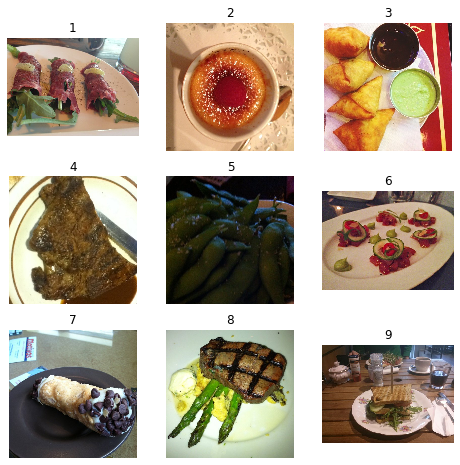

In [ ]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(i)
    plt.axis("off")
    np_img = training_data[sample_idx][0].numpy()
    img = np.transpose(np_img, (1,2,0))       
    img = np.clip(img, 0, 1)
    plt.imshow(img, interpolation='nearest')
plt.show()

## Изучение признаковых пространств за счет deconv

In [17]:
!pip3 install opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.5/60.5 MB 23.3 MB/s eta 0:00:0000:0100:01


In [18]:
import cv2

After 2 epoches
layer...4


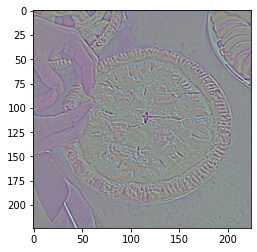

layer...9


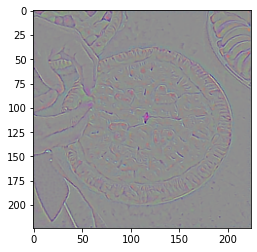

layer...16


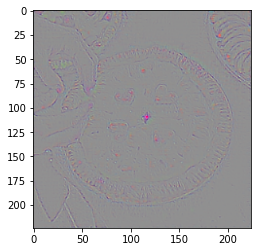

layer...23


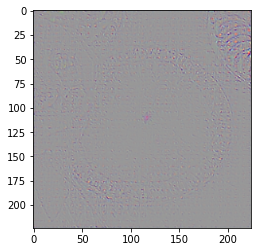

layer...30


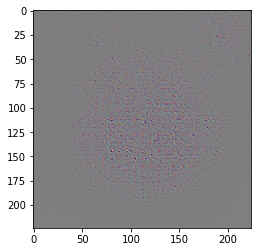

In [45]:
def forward_img(model, x, layer_max_count):
    deconv_layers_list = []
    unpool_layers_list = []

    layer_count = 0

    for layer in model.features:
        if isinstance(layer, torch.nn.Conv2d):
            B, C, H, W = x.shape
            x = layer(x)
            deconv_layer = nn.ConvTranspose2d(layer.out_channels, C, layer.kernel_size, layer.stride, layer.padding)
            deconv_layer.weight = layer.weight
            deconv_layers_list.append(deconv_layer)

        if isinstance(layer, torch.nn.ReLU):
            x = layer(x)
            deconv_layers_list.append(layer)

        if isinstance(layer, torch.nn.MaxPool2d):
            x, index = layer(x)
            unpool_layers_list.append(index)
            unpool_layer = torch.nn.MaxUnpool2d(kernel_size=layer.kernel_size, stride=layer.stride,
                                                padding=layer.padding)
            deconv_layers_list.append(unpool_layer)

        layer_count += 1
        if layer_max_count == layer_count:
            break

    return x, deconv_layers_list, unpool_layers_list


def filter_feature_maps(raw_feature_maps):
    feature_maps = raw_feature_maps[0]
    feature_maps_total_num = feature_maps.shape[0]

    activation_list = []
    for i in range(feature_maps_total_num):
        activation_val = torch.max(feature_maps[i, :, :])
        activation_list.append(activation_val.item())

    max_map_num = np.argmax(np.array(activation_list))
    max_map = feature_maps[max_map_num, :, :]
    max_activation_val = torch.max(max_map)
    max_map = torch.where(max_map == max_activation_val,
                          max_map,
                          torch.zeros(max_map.shape)
                          )

    for i in range(feature_maps_total_num):
        if i != max_map_num:
            feature_maps[i, :, :] = 0
        else:
            feature_maps[i, :, :] = max_map

    return feature_maps.unsqueeze_(0)


def backward_feature_maps(y, deconv_layers_list, unpool_layers_list):
    for layer in reversed(deconv_layers_list):
        if isinstance(layer, nn.MaxUnpool2d):
            y = layer(y, unpool_layers_list.pop())
        else:
            y = layer(y)

    return y


def visualize(layer_max_count, img):
    npimg = img[0].data.numpy()
    npimg = ((npimg - npimg.min()) * 255 / (npimg.max() - npimg.min())).astype('uint8')
    npimg = np.transpose(npimg, (1, 2, 0))
    path = "./output/" + str(layer_max_count) + "th-layer.png"

    plt.imshow(npimg)
    plt.show()
#     plt.imsave(path, npimg)


# raw_img = cv2.imread("/home/kira/DL_CMC/food-101/images/apple_pie/134.jpg")
# raw_img = cv2.cvtColor(raw_img, cv2.COLOR_BGR2RGB)

# resized_img = cv2.resize(raw_img, (224, 224))
raw_img = Image.open(r"/home/kira/DL_CMC/food-101/images/apple_pie/134.jpg") 
transformations = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

input_img = transformations(raw_img).unsqueeze_(0)
model.cpu()

# model = models.vgg16(pretrained=True).eval()
visualize_layer_indices = []

for i, layer in enumerate(model.features):
    if isinstance(layer, torch.nn.MaxPool2d):
        layer.return_indices = True
        visualize_layer_indices.append(i)

print('After 2 epoches')
for layer_max_count in visualize_layer_indices:
    print("layer...%s" % layer_max_count)
    raw_feature_maps, deconv_layers_list, unpool_layers_list = forward_img(model, input_img, layer_max_count)
    #filtered_feature_maps = filter_feature_maps(raw_feature_maps)
    #reproducted_img = backward_feature_maps(filtered_feature_maps, deconv_layers_list, unpool_layers_list)
    reproducted_img = backward_feature_maps(raw_feature_maps, deconv_layers_list, unpool_layers_list)
    visualize(layer_max_count, reproducted_img)

After 2 epoches
layer...4


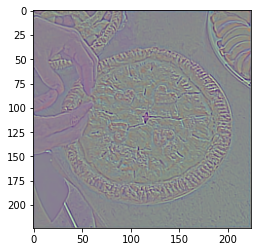

layer...9


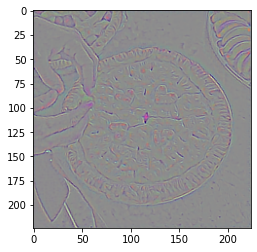

layer...16


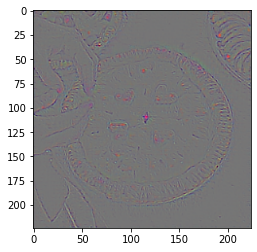

layer...23


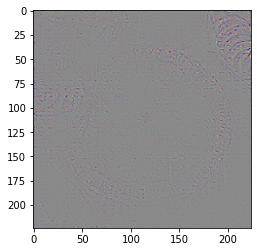

layer...30


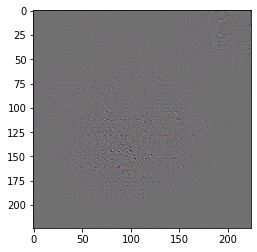

In [59]:
input_img = transformations(raw_img).unsqueeze_(0)
model.cpu()

# model = models.vgg16(pretrained=True).eval()
visualize_layer_indices = []

for i, layer in enumerate(model.features):
    if isinstance(layer, torch.nn.MaxPool2d):
        layer.return_indices = True
        visualize_layer_indices.append(i)

print('After 2 epoches')
for layer_max_count in visualize_layer_indices:
    print("layer...%s" % layer_max_count)
    raw_feature_maps, deconv_layers_list, unpool_layers_list = forward_img(model, input_img, layer_max_count)
    #filtered_feature_maps = filter_feature_maps(raw_feature_maps)
    #reproducted_img = backward_feature_maps(filtered_feature_maps, deconv_layers_list, unpool_layers_list)
    reproducted_img = backward_feature_maps(raw_feature_maps, deconv_layers_list, unpool_layers_list)
    visualize(layer_max_count, reproducted_img)

 #### После 3ех эпох обучения VGG16 результат все еще не очень хороший. Теперь будем работать с AlexNet

In [62]:
# model = models.resnet18(pretrained=True)
model = models.alexnet(pretrained=True)
print(model.classifier[6])
# out: 
# Linear(in_features=512, out_features=1000, bias=True)

num_ftrs = model.classifier[6].in_features

model.classifier[6] = nn.Linear(num_ftrs, 101)
print(model.classifier)
# out: 
# Linear(in_features=512, out_features=2, bias=True)

Linear(in_features=4096, out_features=1000, bias=True)
Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=4096, out_features=101, bias=True)
)


In [63]:
from torch.optim.lr_scheduler import StepLR

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = model.to(device)
criterion = nn.CrossEntropyLoss() 
optimizer = optim.SGD(
                    model.parameters(), 
                    lr=0.001, 
                    momentum=0.9) 
exp_lr_scheduler = StepLR(optimizer, 
                          step_size=7, 
                          gamma=0.1)

In [64]:
device

device(type='cuda', index=0)

In [67]:
num_epochs=25

model.to(device)
for epoch in range(num_epochs):

    model.train()
    running_loss = 0.0
    running_corrects = 0
    count = 0
    
    for inputs, labels in tqdm(train_loader):
        count += 1
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs,1)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()/inputs.size(0)
        running_corrects += torch.sum(preds == labels.data) / inputs.size(0)

    exp_lr_scheduler.step()
    
    train_epoch_loss = running_loss / len(train_loader)
    train_epoch_acc = running_corrects / len(train_loader)

    model.eval() # <3>
    running_loss = 0.0
    running_corrects = 0
    

    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs,1)
        loss = criterion(outputs, labels)

        running_loss += loss.item()/inputs.size(0)
        running_corrects += torch.sum(preds == labels.data) / inputs.size(0)

    epoch_loss = running_loss / len(val_loader)
    epoch_acc = running_corrects.double() / len(val_loader)
    
    print("Train: Loss: {:.4f} Acc: {:.4f}"
          " Val: Loss: {:.4f}"
          " Acc: {:.4f}".format(train_epoch_loss,
                         train_epoch_acc,
                         epoch_loss,
                         epoch_acc))
    
    model.cpu()
    ckpt_model_filename = "alexnet_ckpt_epoch_" + str(epoch) + ".pth"
    ckpt_model_path = os.path.join('/home/kira/DL_CMC', ckpt_model_filename)
    torch.save(model.state_dict(), ckpt_model_path)
    model.to(device)

100%|██████████| 10100/10100 [02:38<00:00, 63.66it/s]


Train: Loss: 0.3366 Acc: 0.3440 Val: Loss: 0.2902 Acc: 0.4294


100%|██████████| 10100/10100 [02:38<00:00, 63.72it/s]


Train: Loss: 0.2802 Acc: 0.4392 Val: Loss: 0.2697 Acc: 0.4588


100%|██████████| 10100/10100 [02:38<00:00, 63.72it/s]


Train: Loss: 0.2497 Acc: 0.4903 Val: Loss: 0.2627 Acc: 0.4758


 51%|█████     | 5175/10100 [01:21<01:17, 63.60it/s]


KeyboardInterrupt: 

In [68]:
torch.save(model.state_dict(), '/home/kira/DL_CMC/alexnet.pth')

layer...2


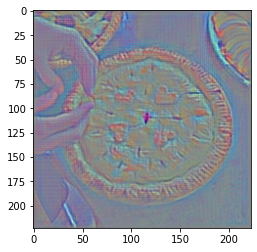

layer...5


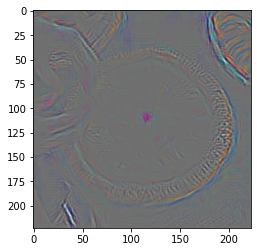

layer...12


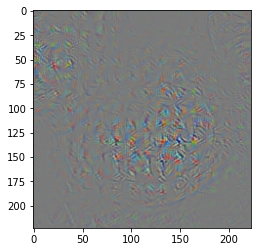

In [72]:
input_img = transformations(raw_img).unsqueeze_(0)
model.cpu()

# model = models.vgg16(pretrained=True).eval()
visualize_layer_indices = []

for i, layer in enumerate(model.features):
    if isinstance(layer, torch.nn.MaxPool2d):
        layer.return_indices = True
        visualize_layer_indices.append(i)

for layer_max_count in visualize_layer_indices:
    print("layer...%s" % layer_max_count)
    raw_feature_maps, deconv_layers_list, unpool_layers_list = forward_img(model, input_img, layer_max_count)
    #filtered_feature_maps = filter_feature_maps(raw_feature_maps)
    #reproducted_img = backward_feature_maps(filtered_feature_maps, deconv_layers_list, unpool_layers_list)
    reproducted_img = backward_feature_maps(raw_feature_maps, deconv_layers_list, unpool_layers_list)
    visualize(layer_max_count, reproducted_img)

Попробуем посмотреть на какие картинки максимально активируется какой слой нейрона

After 2 epoches
layer...2


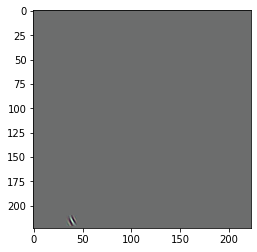

layer...5


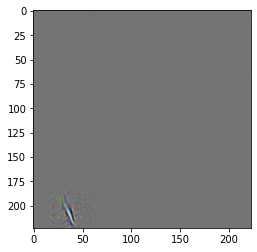

layer...12


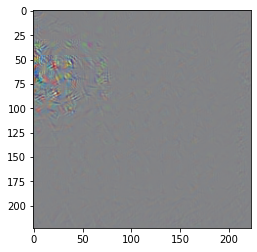

In [73]:
def forward_img(model, x, layer_max_count):
    deconv_layers_list = []
    unpool_layers_list = []

    layer_count = 0

    for layer in model.features:
        if isinstance(layer, torch.nn.Conv2d):
            B, C, H, W = x.shape
            x = layer(x)
            deconv_layer = nn.ConvTranspose2d(layer.out_channels, C, layer.kernel_size, layer.stride, layer.padding)
            deconv_layer.weight = layer.weight
            deconv_layers_list.append(deconv_layer)

        if isinstance(layer, torch.nn.ReLU):
            x = layer(x)
            deconv_layers_list.append(layer)

        if isinstance(layer, torch.nn.MaxPool2d):
            x, index = layer(x)
            unpool_layers_list.append(index)
            unpool_layer = torch.nn.MaxUnpool2d(kernel_size=layer.kernel_size, stride=layer.stride,
                                                padding=layer.padding)
            deconv_layers_list.append(unpool_layer)

        layer_count += 1
        if layer_max_count == layer_count:
            break

    return x, deconv_layers_list, unpool_layers_list


def filter_feature_maps(raw_feature_maps):
    feature_maps = raw_feature_maps[0]
    feature_maps_total_num = feature_maps.shape[0]

    activation_list = []
    for i in range(feature_maps_total_num):
        activation_val = torch.max(feature_maps[i, :, :])
        activation_list.append(activation_val.item())

    max_map_num = np.argmax(np.array(activation_list))
    max_map = feature_maps[max_map_num, :, :]
    max_activation_val = torch.max(max_map)
    max_map = torch.where(max_map == max_activation_val,
                          max_map,
                          torch.zeros(max_map.shape)
                          )

    for i in range(feature_maps_total_num):
        if i != max_map_num:
            feature_maps[i, :, :] = 0
        else:
            feature_maps[i, :, :] = max_map

    return feature_maps.unsqueeze_(0)


def backward_feature_maps(y, deconv_layers_list, unpool_layers_list):
    for layer in reversed(deconv_layers_list):
        if isinstance(layer, nn.MaxUnpool2d):
            y = layer(y, unpool_layers_list.pop())
        else:
            y = layer(y)

    return y


def visualize(layer_max_count, img):
    npimg = img[0].data.numpy()
    npimg = ((npimg - npimg.min()) * 255 / (npimg.max() - npimg.min())).astype('uint8')
    npimg = np.transpose(npimg, (1, 2, 0))
    path = "./output/" + str(layer_max_count) + "th-layer.png"

    plt.imshow(npimg)
    plt.show()

raw_img = Image.open(r"/home/kira/DL_CMC/food-101/images/apple_pie/134.jpg") 
transformations = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

input_img = transformations(raw_img).unsqueeze_(0)
model.cpu()

# model = models.vgg16(pretrained=True).eval()
visualize_layer_indices = []

for i, layer in enumerate(model.features):
    if isinstance(layer, torch.nn.MaxPool2d):
        layer.return_indices = True
        visualize_layer_indices.append(i)

print('After 2 epoches')
for layer_max_count in visualize_layer_indices:
    print("layer...%s" % layer_max_count)
    raw_feature_maps, deconv_layers_list, unpool_layers_list = forward_img(model, input_img, layer_max_count)
    filtered_feature_maps = filter_feature_maps(raw_feature_maps)
    reproducted_img = backward_feature_maps(filtered_feature_maps, deconv_layers_list, unpool_layers_list)
#     reproducted_img = backward_feature_maps(raw_feature_maps, deconv_layers_list, unpool_layers_list)
    visualize(layer_max_count, reproducted_img)

In [ ]:
for i, layer in enumerate(model.features):
    if isinstance(layer, torch.nn.MaxPool2d):
        layer.return_indices = True
        visualize_layer_indices.append(i)

ind = 1
plt.figure(figsize=[20,50])
for layer in out_cpu:
#   SELECTING A RANDOM ACTIVATION MAP
    filter_random = out_cpu[layer][0][np.random.randint(0,np.shape(out_cpu[layer])[1])]
    plot_loc = plt.subplot(13,3,ind)
    ind += 1
    vis = transforms.ToPILImage()(filter_random)
    plt.imshow(vis,cmap='magma')
    plt.colorbar()
    
#   SELECTING MAX ACTIVATION MAP
    filter_max = out_cpu[layer][0][0]
    max_norm = filter_max.norm()
    for filters in out_cpu[layer][0][1:]:
        if filters.norm() > max_norm :
            max_norm = filters.norm()
            filter_max = filters
    vis_mean = transforms.ToPILImage()(filter_max)
    plot_loc = plt.subplot(13,3,ind)
    ind += 1    
    plt.imshow(vis_mean,cmap='magma')
    plt.colorbar()
    
#     CALCULATING MEAN OF ALL ACTIVATION MAPS IN THE LAYER
    mean = torch.zeros(np.shape(out_cpu[layer])[2],np.shape(out_cpu[layer])[3])
    for i in out_cpu[layer][0]:
        mean += i
    vis_mean = transforms.ToPILImage()(mean/np.shape(out_cpu[layer])[1])
    plot_loc = plt.subplot(13,3,ind)
    
    ind += 1    
    plt.imshow(vis_mean,cmap='magma')
    plt.colorbar()



In [ ]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(i)
    plt.axis("off")
    np_img = training_data[sample_idx][0].numpy()
    img = np.transpose(np_img, (1,2,0))       
    img = np.clip(img, 0, 1)
    plt.imshow(img, interpolation='nearest')
plt.show()

In [20]:
# model = models.resnet18(pretrained=True)
model = models.densenet161(pretrained=True)
print(model.classifier)
# out: 
# Linear(in_features=512, out_features=1000, bias=True)

num_ftrs = model.classifier.in_features

model.classifier = nn.Linear(num_ftrs, 101)
print(model.classifier)
# out: 
# Linear(in_features=512, out_features=2, bias=True)

Linear(in_features=2208, out_features=1000, bias=True)
Linear(in_features=2208, out_features=101, bias=True)


In [21]:
model.load_state_dict(torch.load('/home/kira/DL_CMC/densenet.pth'))

<All keys matched successfully>

In [24]:
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel